In [86]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [111]:

# Reading the dataset
# 2 modes: 'file' or 'folder'
def load_path(dataset_path, mode):
    imagepaths, labels = list(), list()
    if mode == 'file':
        # Read dataset file
        data = open(dataset_path, 'r').read().splitlines()
        for d in data:
            imagepaths.append(d.split(' ')[0])
            labels.append(int(d.split(' ')[1]))
    elif mode == 'folder':
        # An ID will be affected to each sub-folders by alphabetical order
        label = 0
        # List the directory
        try:  # Python 2
            classes = sorted(os.walk(dataset_path).next()[1])
        except Exception:  # Python 3
            classes = sorted(os.walk(dataset_path).__next__()[1])
        # List each sub-directory (the classes)
        for c in classes:
            c_dir = os.path.join(dataset_path, c)
            try:  # Python 2
                walk = os.walk(c_dir).next()
            except Exception:  # Python 3
                walk = os.walk(c_dir).__next__()
            # Add each image to the training set
            for sample in walk[2]:
                # Only keeps jpeg images
                if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                    imagepaths.append(os.path.join(c_dir, sample))
                    labels.append(label)
            label += 1
    else:
        raise Exception("Unknown mode.")
    print('Number of Images: {}, Number of Labels: {}'.format(len(imagepaths),len(labels)))
    print('Number of classes: {}.'.format(np.max(labels)+1))
    return imagepaths,  labels



def split_data(imagepaths, labels):
    X_train, X_test, y_train, y_test = train_test_split(imagepaths, labels, 
                                                    test_size=0.2, 
                                                    random_state=0)
    return X_train, y_train, X_test, y_test


def create_dataset(X,y, batch_size = 128, buffer_size = 1024):
    X = tf.convert_to_tensor(X, dtype=tf.string)
    y = tf.convert_to_tensor(y, dtype=tf.int32)  
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(preprocess)
    # you can do almost all sorts of custom preprocesses....
    dataset = dataset.shuffle(buffer_size = buffer_size)
    dataset = dataset.batch(batch_size = batch_size)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset


@tf.function
def read_image(image_path):
    image = tf.io.read_file(image_path)
    # tensorflow provides quite a lot of apis for io
    image = decode_img(image)
    return image


def decode_img(img, size = 160):
    img = tf.image.decode_jpeg(img, channels=3) #color images
    img = tf.image.convert_image_dtype(img, tf.float32) 
       #convert unit8 tensor to floats in the [0,1]range
    return tf.image.resize(img, [size, size]) 


@tf.function
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.5, 2.0)
    image = tf.image.random_brightness(image, 0.5)
    return image


@tf.function
def normalize(image):
    image = (image - tf.reduce_min(image))/(tf.reduce_max(image) - tf.reduce_min(image))
    image = (2 * image) - 1
    return image


@tf.function
def preprocess(image_path, label):
    image = read_image(image_path)
    image = augment(image)
    image = normalize(image)
    return image, label

def backTonumpy(dataset):
    x = []
    y = []
    for sample in dataset:
        x.append(sample[0].numpy())
        y.append(sample[1].numpy())

    x = np.asarray(x)
    y = np.asarray(y)

    x = np.concatenate(x)
    y = np.concatenate(y)
    
    return x, y

def laod_dataset(dataset_path, mode = 'folder',  batch_size = 128, buffer_size = 1024):
    imagepaths,  labels = load_path(dataset_path, mode)
    X_train, y_train, X_test, y_test = split_data(imagepaths, labels)
    train_dataset = create_dataset(X_train, y_train , batch_size = batch_size, buffer_size = buffer_size)
    test_dataset = create_dataset(X_test, y_test , batch_size = batch_size, buffer_size = buffer_size)
    return train_dataset, test_dataset

Number of Images: 17534, Number of Labels: 17534
Number of classes: 105.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(85, shape=(), dtype=int32)


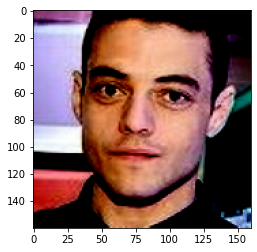

In [118]:
if __name__ == "__main__":
    dataset_path = 'C:\\Users\\ziaeeamir\\Desktop\\Face\\Face-Recognition-and-Verification\\Codes\\dataset\\'
    train_dataset, test_dataset  = laod_dataset(dataset_path, mode = 'folder',  batch_size = 128, buffer_size = 1024)
    for img, label in train_dataset.take(1):
        plt.imshow(img[0,:,:,:])
        print(label[0])